In [1]:
__author__ = "Nurdinov Rostislav"
__date__ = "2022-06-13"

# Initializing

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm

from PIL import Image
import cv2

import torch
from torch.utils.data import DataLoader
from torch.nn.functional import softmax

from src.augmentations import test_transforms
from src.dataset import ContainerDataset

# Metrics and cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [14]:
# Path
ROOT = Path.cwd()
PATH_TO_MODEL = ROOT / ".." / "models/traced-best-forward.pth"
PATH_TO_TEST_DF = ROOT / ".." / "data" / "processed" / "test" / "data.csv"

In [15]:
# plt settings
plt.rcParams["font.size"] = 15

# Test DataFrame reading

In [16]:
df = pd.read_csv(PATH_TO_TEST_DF)
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

file_name container  \
0                    1469_4901112680592_47241604.jpg     glass   
1                         64_4902105042076_42933.png     glass   
2  1381_49698640_1902076-f5f26d56-b4a6-4345-b07f-...     glass   
3                         69_4909411045692_78308.png    bottle   
4                         6_4902152011803_433944.jpg    packet   

                                          image_path  
0  /home/nurdinov/Desktop/quatra_rad/data/process...  
1  /home/nurdinov/Desktop/quatra_rad/data/process...  
2  /home/nurdinov/Desktop/quatra_rad/data/process...  
3  /home/nurdinov/Desktop/quatra_rad/data/process...  
4  /home/nurdinov/Desktop/quatra_rad/data/process...

In [17]:
dataset_test = ContainerDataset(df, mode="test", transform=test_transforms)
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False, drop_last=False)

In [18]:
df.container.value_counts()

packet    66
bottle    66
glass     63
Name: container, dtype: int64

In [19]:
df.shape

(195, 3)

# Load model and get predictions

In [20]:
device = torch.device("cuda")
model = torch.jit.load(str(PATH_TO_MODEL), map_location=device)
model.eval()

RecursiveScriptModule(
  original_name=_ForwardOverrideModel
  (model): RecursiveScriptModule(
    original_name=ContainersModel
    (model): RecursiveScriptModule(
      original_name=EfficientNet
      (conv_stem): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (act1): RecursiveScriptModule(original_name=SiLU)
      (blocks): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(
            original_name=DepthwiseSeparableConv
            (conv_dw): RecursiveScriptModule(original_name=Conv2d)
            (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
            (act1): RecursiveScriptModule(original_name=SiLU)
            (se): RecursiveScriptModule(
              original_name=SqueezeExcite
              (conv_reduce): RecursiveScriptModule(original_name=Conv2d)
              (act1): RecursiveScriptM

In [21]:
preds = []
labels = []
image_paths = []
with torch.no_grad():
    for inputs in tqdm(test_dataloader):
        images = inputs["features"].to(device)
        targets = inputs["targets"].to("cpu")
        image_path = inputs["path"][0]
        pred = model(images)
        preds.append(torch.argmax(softmax(pred, dim=1), dim=1).data.cpu().item())
        labels.append(targets.data.item())
        image_paths.append(image_path)

preds = np.array(preds)
labels = np.array(labels)
image_paths = np.array(image_paths)

  0%|          | 0/195 [00:00<?, ?it/s]

# Evaluation and metrics

In [22]:
acc = accuracy_score(labels, preds)
print(f"Accuracy score: {acc}")

Accuracy score: 0.9384615384615385


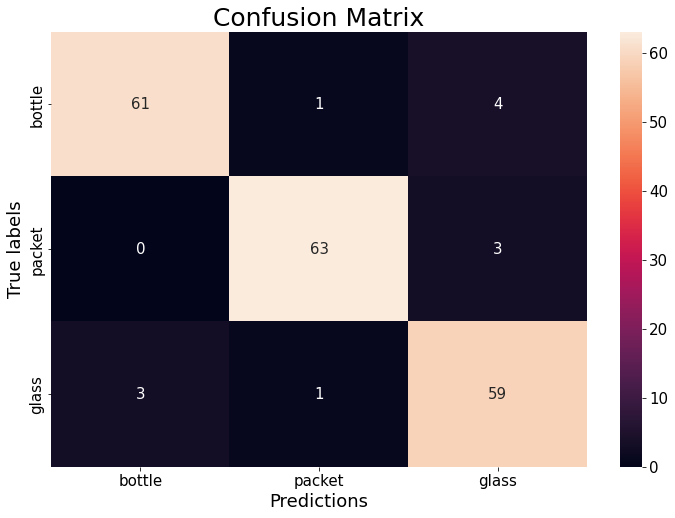

In [23]:
plt.figure(figsize=(12, 8))

# Calculate a confusion matrix
cm = confusion_matrix(labels, preds)
names = ["bottle", "packet", "glass"]

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel("Predictions", size=18)
ax.set_ylabel("True labels", size=18)
ax.set_title("Confusion Matrix", size=25)
ax.xaxis.set_ticklabels(names, size=15)
ax.yaxis.set_ticklabels(names, size=15)

plt.show()

# Visualizing all incorrect predictions

In [24]:
# Get index of incorrect prediction
decode = {
    0: "bottle",
    1: "packet",
    2: "glass",
}

df_result = pd.DataFrame({
    "image_path": image_paths,
    "pred": preds,
})
df_result.pred = df_result.apply(lambda row: decode[row.pred], axis=1)

df_result.head()

image_path    pred
0  /home/nurdinov/Desktop/quatra_rad/data/process...   glass
1  /home/nurdinov/Desktop/quatra_rad/data/process...   glass
2  /home/nurdinov/Desktop/quatra_rad/data/process...   glass
3  /home/nurdinov/Desktop/quatra_rad/data/process...  bottle
4  /home/nurdinov/Desktop/quatra_rad/data/process...  packet

In [25]:
df_merge = pd.merge(
    left=df,
    right=df_result,
    how="inner",
    on="image_path"
)

display(df_merge.head())
print(df_merge.shape)

file_name container  \
0                    1469_4901112680592_47241604.jpg     glass   
1                         64_4902105042076_42933.png     glass   
2  1381_49698640_1902076-f5f26d56-b4a6-4345-b07f-...     glass   
3                         69_4909411045692_78308.png    bottle   
4                         6_4902152011803_433944.jpg    packet   

                                          image_path    pred  
0  /home/nurdinov/Desktop/quatra_rad/data/process...   glass  
1  /home/nurdinov/Desktop/quatra_rad/data/process...   glass  
2  /home/nurdinov/Desktop/quatra_rad/data/process...   glass  
3  /home/nurdinov/Desktop/quatra_rad/data/process...  bottle  
4  /home/nurdinov/Desktop/quatra_rad/data/process...  packet

(195, 4)


# Visualizing incorrect predictions

In [26]:
df_incorrect = df_merge[df_merge.container != df_merge.pred]

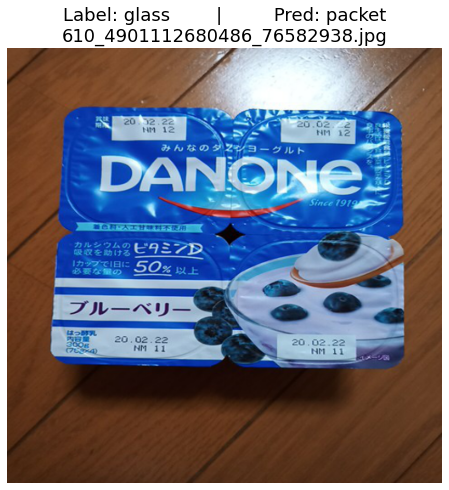

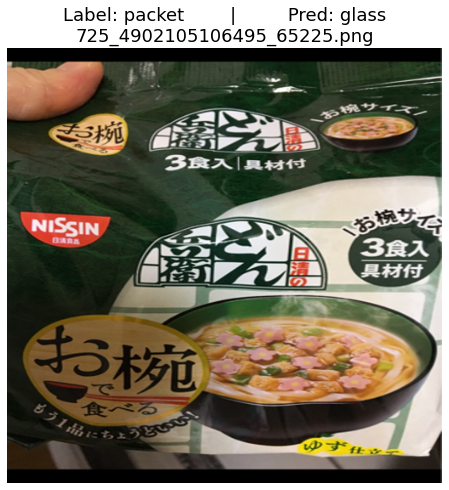

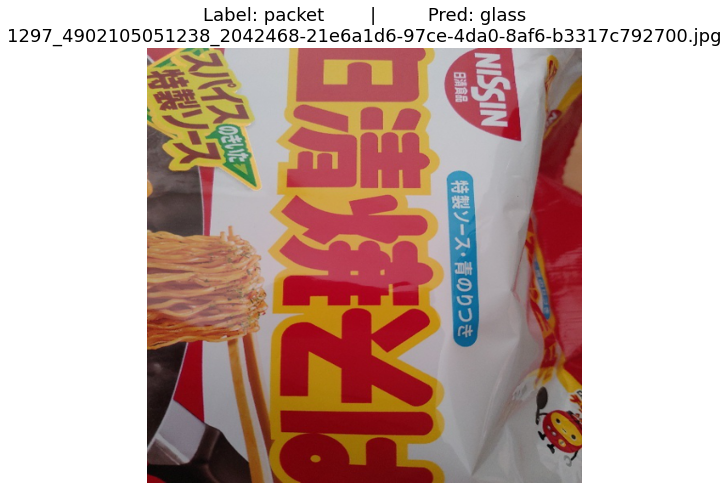

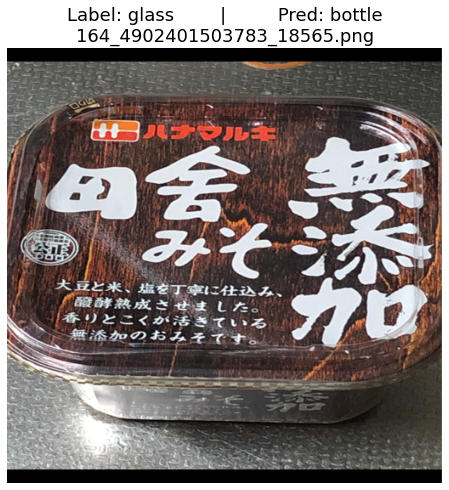

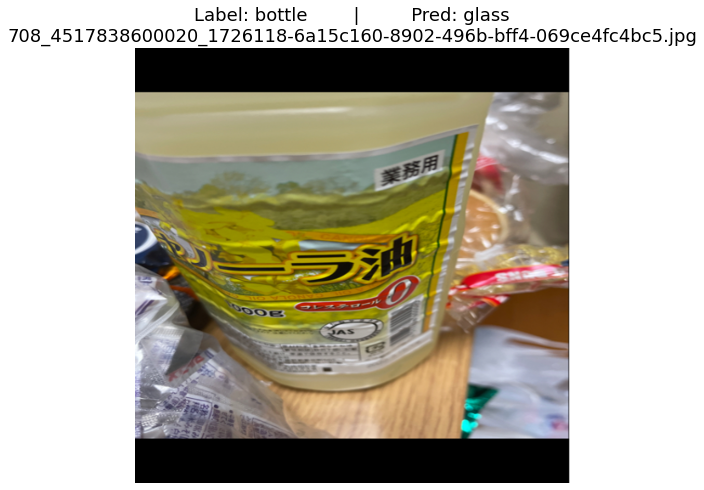

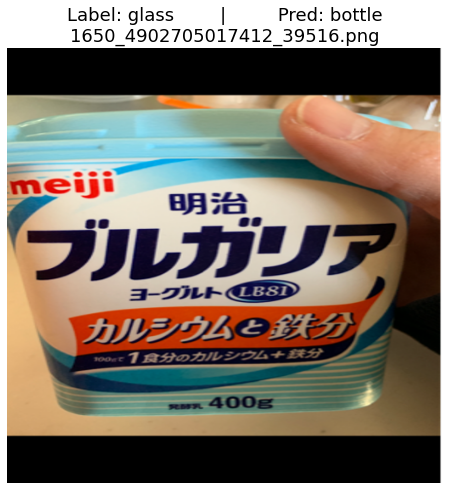

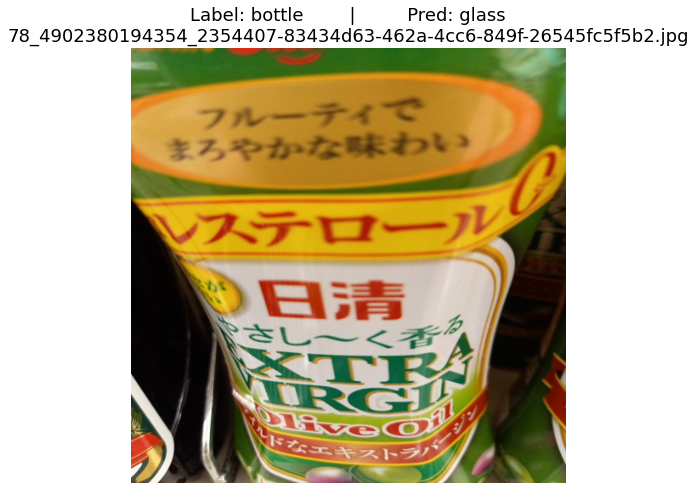

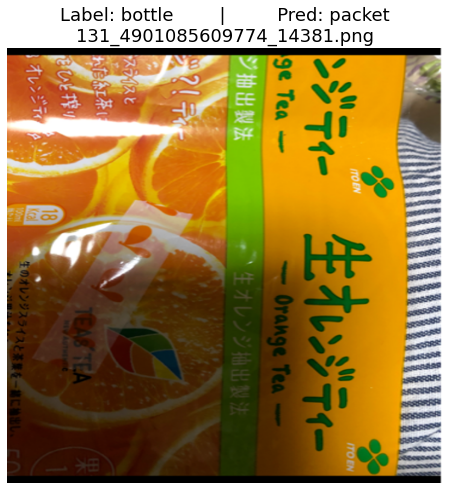

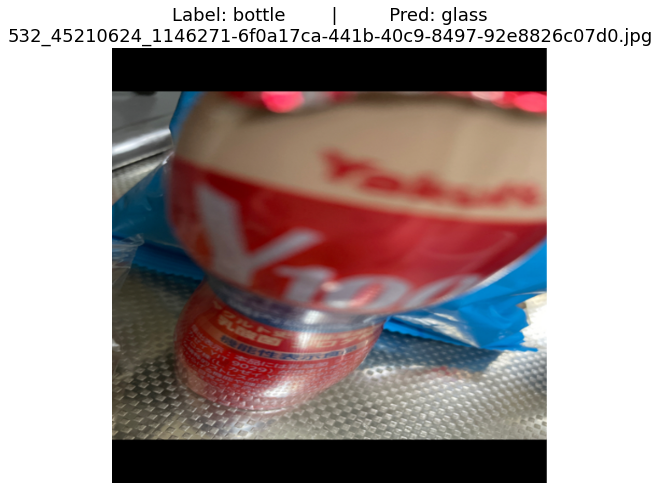

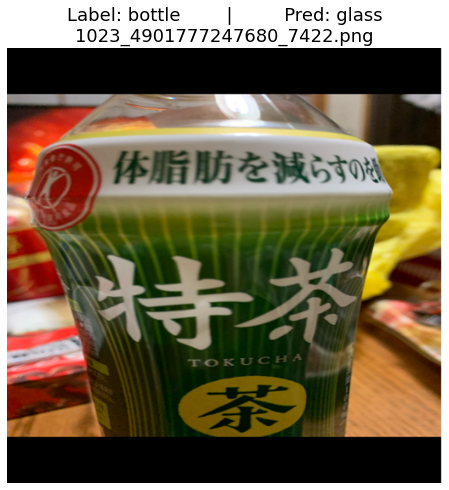

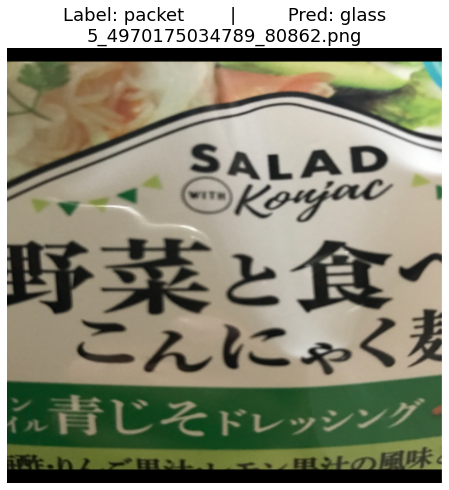

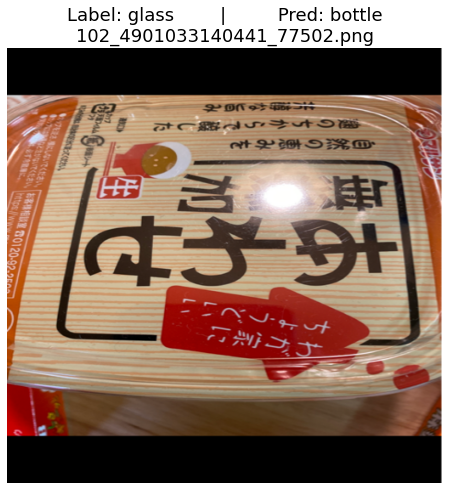

In [27]:
IMAGE_SIZE = 512

for i, row in df_incorrect.iterrows():
    plt.figure(figsize=(8, 8))
    path = row.image_path
    y_true = row.container
    y_pred = row.pred
    image = Image.open(path).resize((IMAGE_SIZE, IMAGE_SIZE))
    
    plt.title(f"Label: {y_true}        |         Pred: {y_pred}\n{row.file_name}")
    plt.imshow(image)
    plt.axis("off")
    plt.show()